In [ ]:
import Quant.getSECData as getSECData

# fil = getSECData.parseSECData()  
dat = getSECData.getAlphaVantageData(1000)

SPY is in the ban list, skipping...
Fetching Alpha Vantage data for CYATY...
Fetching income statement data for CYATY...
No Quarterly Reports found for CYATY
No income statement data for CYATY, skipping...
No data fetched for CYATY, skipping...
Fetching Alpha Vantage data for QQQ...
Fetching income statement data for QQQ...
No Quarterly Reports found for QQQ
No income statement data for QQQ, skipping...
No data fetched for QQQ, skipping...
Fetching Alpha Vantage data for DTEGY...
Fetching income statement data for DTEGY...
No Quarterly Reports found for DTEGY
No income statement data for DTEGY, skipping...
No data fetched for DTEGY, skipping...
Fetching Alpha Vantage data for UTX...
Fetching income statement data for UTX...
No Quarterly Reports found for UTX
No income statement data for UTX, skipping...
No data fetched for UTX, skipping...
Fetching Alpha Vantage data for RTNTF...
Fetching income statement data for RTNTF...
No Quarterly Reports found for RTNTF
No income statement data f

In [ ]:
import Quant.Value as qv
import Quant.Signals as qs
import numpy as np
import pandas as pd
from sklearn.decomposition import SparsePCA
import matplotlib.pyplot as plt

tickers, d = qv.get_all_tickers('./tickers.csv')


balance, price_data, info, raw_info, income, earnings = qv.Book_to_Market_Ratio_Multi_Asset(tickers )
tickers = balance.index.get_level_values('Ticker').unique().tolist()
dates = balance.index.get_level_values('Report Date').unique().tolist()
balance['Equity'] = balance['Equity'].where(balance['Equity'] != 0, balance['Assets'] - balance['Liabilities'])
TICKERS = tickers



Loaded 4185 tickers from cache file ./tickers.csv.
Dataset "us-balance-quarterly" on disk (3 days old).
- Loading from disk ... 

C:\Users\adamd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\simfin\load.py:154: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(path, sep=';', header=0,


Done!
Dataset "us-balance-banks-quarterly" on disk (3 days old).
- Loading from disk ... Done!
Dataset "us-balance-insurance-quarterly" on disk (3 days old).
- Loading from disk ... Done!
Dataset "us-income-quarterly" on disk (3 days old).
- Loading from disk ... 

C:\Users\adamd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\simfin\load.py:154: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(path, sep=';', header=0,
C:\Users\adamd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\simfin\load.py:154: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(path, sep=';', header=0,
C:\Users\adamd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\simfin\load.py:154: FutureWarning: The argument 'date_par

Done!
Dataset "us-income-banks-quarterly" on disk (3 days old).
- Loading from disk ... Done!
Dataset "us-income-insurance-quarterly" on disk (3 days old).
- Loading from disk ... Done!
['A', 'AA', 'AAC', 'AACI', 'AACT', 'AAGH', 'AAL', 'AAMC', 'AAN', 'AAOI', 'AAON', 'AAPL', 'AAT', 'AAWH', 'AAWW', 'ABBV', 'ABCL', 'ABIO', 'ABM', 'ABMC', 'ABMD', 'ABML', 'ABNB', 'ABOS', 'ABR', 'ABSI', 'ABT', 'ABTL', 'ABUS', 'AC', 'ACA', 'ACAC', 'ACAH', 'ACAN', 'ACAQ', 'ACBA', 'ACBM', 'ACC', 'ACCD', 'ACCO', 'ACEL', 'ACER', 'ACET', 'ACHC', 'ACHR', 'ACHV', 'ACIA', 'ACIW', 'ACLS', 'ACLX', 'ACMR', 'ACN', 'ACOR', 'ACRE', 'ACRO', 'ACRS', 'ACRV', 'ACRX', 'ACTG', 'ACTU', 'ACU', 'ACVA', 'ACXP', 'ADAP', 'ADBE', 'ADCT', 'ADER', 'ADES', 'ADEX', 'ADI', 'ADM', 'ADMA', 'ADMP', 'ADMS', 'ADN', 'ADNT', 'ADP', 'ADPT', 'ADRT', 'ADSK', 'ADTN', 'ADUS', 'ADV', 'AE', 'AEE', 'AEHA', 'AEHR', 'AEO', 'AERC', 'AERG', 'AERI', 'AESI', 'AEVA', 'AEYE', 'AFAR', 'AFCG', 'AFI', 'AFIB', 'AFRM', 'AGBA', 'AGCO', 'AGE', 'AGEN', 'AGFS', 'AGIO', 'A

C:\Users\adamd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\simfin\load.py:154: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(path, sep=';', header=0,
C:\Users\adamd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\simfin\load.py:154: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(path, sep=';', header=0,


Found Data for 2613 assets.
Fetching price data for 2613 tickers...
Loaded price data from cache file ../simfin_data/yf_price_cache/price_data.h5.
Fetching balance sheet data for 2613 tickers...
Loaded balance sheet data from cache file ../simfin_data/yf_balance_cache/balance_sheet.h5.
Fetching income sheet data for 2613 tickers...
Loaded income sheet data from cache file ../simfin_data/yf_income_cache/income_sheet.h5.
Fetching earnings dates data for 2613 tickers...
Processing AMTD: [##--------------------------------------] 5%    OpenBB earnings dates fetch failed for AMTD with error: 
[Empty] -> No filings were found using the filters provided.
Processing ASTL: [###-------------------------------------] 8%    OpenBB earnings dates fetch failed for ASTL with error: 
[Empty] -> No filings were found using the filters provided.
Processing B: [####------------------------------------] 10%      OpenBB earnings dates fetch failed for B with error: 
[Empty] -> No filings were found using t

In [ ]:
price_data = price_data.tz_localize(None)

ret_1m_daily_avg_log = np.log( (price_data / price_data.shift(21))) / 21
ret_3m_daily_avg_log = np.log( (price_data / price_data.shift(63))) / 63
ret_6m_daily_avg_log = np.log( (price_data / price_data.shift(126))) / 126
ret_12m_daily_avg_log = np.log( (price_data / price_data.shift(252))) / 252
ret_12m_skip_prev_month_daily_avg_log = np.log( ( price_data.shift(21) / price_data.shift(252) )) / (252-21)


pricevsEMA200 = price_data / qs.EWMA(price_data, window=200)
pricevsEMA50 = price_data / qs.EWMA(price_data, window=50)

high_52w = price_data.fillna(method='ffill').rolling(window=252).max()
low_52w = price_data.fillna(method='ffill').rolling(window=252).min()
distanceFromHigh = (price_data - high_52w) / high_52w
distanceFromLow = (price_data - low_52w) / low_52w

AttributeError: 'int' object has no attribute 'tz_localize'

In [ ]:
plotData = False
stats = pd.DataFrame(0, index=tickers, columns=['Display Name', 'Sector', 'Industry', 'MomentumScore', 'PriceToBook', 'ROE', 'IncomeGrowth'])
stats['Display Name'] = info['displayName']
stats['Sector'] = info['sector']
stats['Industry'] = info['industry']
stats_last = stats.copy()

for ticker in tickers:
    SharesToBook = balance.loc[ticker]['Shares'] / balance.loc[ticker]['Equity'].replace(0, np.nan)
    ReturnOnEquity = income.loc[ticker]['Net Income'] / balance.loc[ticker]['Equity'].replace(0, np.nan)
    NetIncome = income.loc[ticker]['Net Income']

    momentum_score = 0.5 * ret_6m_daily_avg_log[ticker] + 0.3 * ret_3m_daily_avg_log[ticker] + 0.2 * ret_1m_daily_avg_log[ticker]
    PriceToBook = SharesToBook.reindex_like(price_data[ticker], method='ffill') * price_data[ticker]
    ROE = ReturnOnEquity.reindex_like(price_data[ticker], method='ffill') * 100


    FiscalYear = balance.loc[ticker]['Fiscal Year']
    FiscalPeriod = balance.loc[ticker]['Fiscal Period']
    JoinedFiscalPeriod = FiscalPeriod + '_' + FiscalYear.astype(str)
    sbs = pd.DataFrame({'JoinedFiscalPeriod': JoinedFiscalPeriod, 'NetIncome': NetIncome})


    IncomeGrowth = (NetIncome / NetIncome.shift(1).replace(0, np.nan) - 1).reindex_like(price_data[ticker], method='ffill') * 100
    stats.at[ticker, 'MomentumScore'] = momentum_score.mean()
    stats.at[ticker, 'PriceToBook'] = PriceToBook.mean()
    stats.at[ticker, 'ROE'] = ROE.mean()
    stats.at[ticker, 'IncomeGrowth'] = IncomeGrowth.mean()
    stats_last.at[ticker, 'MomentumScore'] = momentum_score.iloc[-1]
    stats_last.at[ticker, 'PriceToBook'] = PriceToBook.iloc[-1]
    stats_last.at[ticker, 'ROE'] = ROE.iloc[-1]
    stats_last.at[ticker, 'IncomeGrowth'] = IncomeGrowth.iloc[-1]

    # raise Exception("Stop")

    if plotData:
        fig, ax1 = plt.subplots(figsize=(12, 8))

        # Left axis: Momentum and ROE
        ax1.plot(momentum_score * 2000, label='Momentum Score', color='tab:blue', linewidth=2)
        ax1.plot(ROE, label='% Return on Equity', color='tab:green', linewidth=2)
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Momentum / ROE', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)

        # Right axis: Price to Book
        ax2 = ax1.twinx()
        ax2.plot(PriceToBook, label='Price to Book', color='tab:red', linewidth=2, linestyle='--')
        ax2.set_ylabel('Price to Book', fontsize=12, color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax2.legend(loc='upper right')

        # Title
        plt.title(f'{ticker} - Momentum, ROE, and Price to Book', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()


    # raise Exception("Stop")
means = stats[['MomentumScore', 'PriceToBook', 'ROE', 'IncomeGrowth']].mean()
stds = stats[['MomentumScore', 'PriceToBook', 'ROE', 'IncomeGrowth']].std()
print("Overall Means:")
print(means)
print("Overall Standard Deviations:")
print(stds)


C:\Users\adamd\AppData\Local\Temp\ipykernel_37840\2435068028.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00033230432120718006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stats.at[ticker, 'MomentumScore'] = momentum_score.mean()
C:\Users\adamd\AppData\Local\Temp\ipykernel_37840\2435068028.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.837870679126017' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stats.at[ticker, 'PriceToBook'] = PriceToBook.mean()
C:\Users\adamd\AppData\Local\Temp\ipykernel_37840\2435068028.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.201305807323633' has dtype incompatible with int64, please explicitly cast 

Overall Means:
MomentumScore       -0.000122
PriceToBook         68.910074
ROE                253.738867
IncomeGrowth    -62981.118913
dtype: float64
Overall Standard Deviations:
MomentumScore    1.372502e-03
PriceToBook      2.399499e+03
ROE              2.005075e+04
IncomeGrowth     3.263379e+06
dtype: float64


C:\Users\adamd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
C:\Users\adamd\AppData\Local\Temp\ipykernel_37840\1198612863.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.159533761194238' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.loc[ticker, 'CAGR'] = (1 + cum_rets.iloc[-1]) ** (1 / y_cagr) - 1
C:\Users\adamd\AppData\Local\Temp\ipykernel_37840\1198612863.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.06313640868884744' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.loc[ticker, 'Volatility'] = rets.std() * n

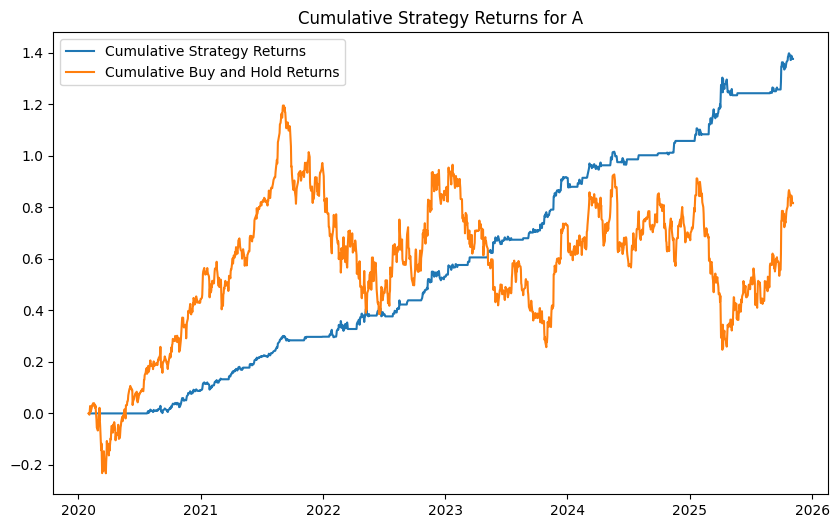

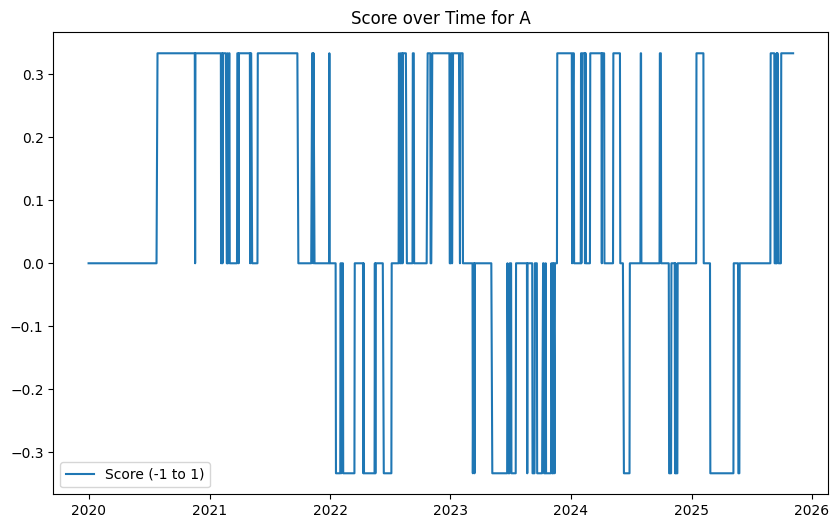

In [ ]:
results = pd.DataFrame(0, index=tickers, columns=['CAGR', 'Volatility', 'SharpeRatio'])
logrets = np.log( price_data / price_data.shift(1) )


returns = pd.Series(1, index=tickers)
weights = pd.Series(1/len(tickers), index=tickers)



for ticker in tickers[0]:

    SharesToBook = balance.loc[ticker]['Shares'] / balance.loc[ticker]['Equity'].replace(0, np.nan)
    ReturnOnEquity = income.loc[ticker]['Net Income'] / balance.loc[ticker]['Equity'].replace(0, np.nan)
    NetIncome = income.loc[ticker]['Net Income']
  
    momentum_score = (0.5 * ret_6m_daily_avg_log[ticker] + 0.3 * ret_3m_daily_avg_log[ticker] + 0.2 * ret_1m_daily_avg_log[ticker] - means['MomentumScore']) / stds['MomentumScore']
    PriceToBook = (SharesToBook.reindex_like(price_data, method='ffill') * price_data[ticker] - means['PriceToBook']) / stds['PriceToBook']
    ROE = (ReturnOnEquity.reindex_like(price_data, method='ffill') * 100 - means['ROE']) / stds['ROE']
    IncomeGrowth = ((NetIncome / NetIncome.shift(1).replace(0, np.nan) - 1).reindex_like(price_data, method='ffill') * 100 - means['IncomeGrowth']) / stds['IncomeGrowth']

    score = -1 * (momentum_score < -1).astype(int) + 1 * (momentum_score > 1).astype(int)
    score += -1 * (PriceToBook < -1).astype(int) + 1 * (PriceToBook > 1).astype(int)
    score += -1 * (ROE < -1).astype(int) + 1 * (ROE > 1).astype(int)
    score += -1 * (IncomeGrowth < -1).astype(int) + 1 * (IncomeGrowth > 1).astype(int)
    score = score.clip(-3,3)/3

    rets = score * np.log( price_data[ticker] / price_data[ticker].shift(1) )
    cum_rets = np.exp( rets.cumsum() ) - 1

    y_cagr = (cum_rets.index[-1] - cum_rets.index[0]).days / 365.25
    results.loc[ticker, 'CAGR'] = (1 + cum_rets.iloc[-1]) ** (1 / y_cagr) - 1
    results.loc[ticker, 'Volatility'] = rets.std() * np.sqrt(252)
    results.loc[ticker, 'SharpeRatio'] = results.loc[ticker, 'CAGR'] / results.loc[ticker, 'Volatility']

    plt.figure(figsize=(10,6))
    plt.plot(cum_rets, label='Cumulative Strategy Returns')
    plt.plot( price_data[ticker] / price_data[ticker].dropna().iloc[0]-1, label='Cumulative Buy and Hold Returns' )
    plt.title(f'Cumulative Strategy Returns for {ticker}')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(score, label='Score (-1 to 1)')
    plt.title(f'Score over Time for {ticker}')
    plt.legend()
    plt.show()

    # raise Exception("Stop")

C:\Users\adamd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
C:\Users\adamd\AppData\Local\Temp\ipykernel_37840\1064294282.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3333333333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  score_vec.loc[date, ticker] = score
C:\Users\adamd\AppData\Local\Temp\ipykernel_37840\1064294282.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3333333333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  score_vec.loc[date, ticker] = score
C:\Users\adamd\AppData\Local\Temp\ipykernel_37840\10

Final Results:
          CAGR  Volatility  SharpeRatio
A     0.153559    0.063136     2.432184
AA    0.399629    0.152767     2.615933
AAL   0.248382    0.122639     2.025316
AAME  0.401759    0.199092     2.017959
AAOI  0.685130    0.304026     2.253524
AAPL  0.142469    0.069799     2.041131
AAT   0.141081    0.067036     2.104568
AAWH  0.452452    0.238222     1.899286
ABBV  0.108873    0.040432     2.692713
ABCL  0.406086    0.179663     2.260269


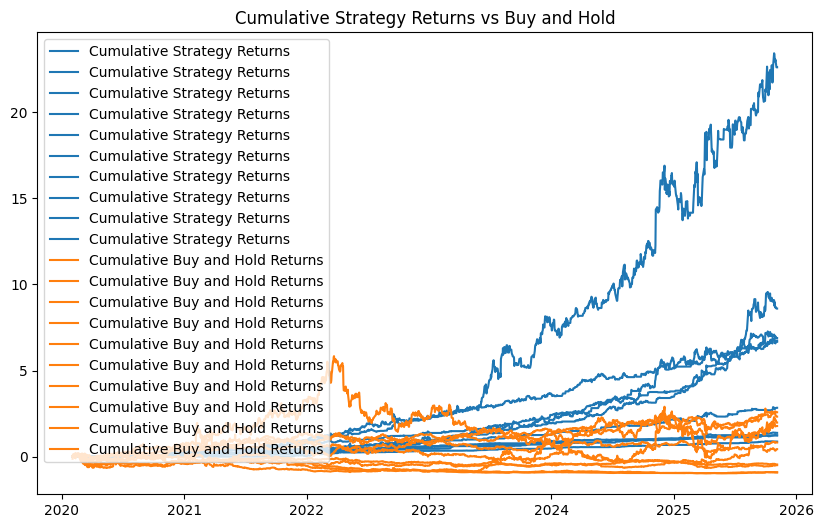

In [ ]:
tickers = TICKERS[:10]

results = pd.DataFrame(0, index=tickers, columns=['CAGR', 'Volatility', 'SharpeRatio'])
score_vec = pd.DataFrame(0, index=price_data.index, columns=tickers)
logrets = np.log( price_data / price_data.shift(1) )

startTimeDelta = pd.Timedelta(days=182)
ReblanceDates = balance.index.get_level_values('Report Date').tz_localize(None).unique().sort_values().tolist()
returns = pd.Series(1, index=tickers)
weights = pd.Series(1/len(tickers), index=tickers)
period_mask = None
missing_mask = None
startDate = ReblanceDates[5]

for i, date in enumerate(price_data.index[(price_data.index >= price_data.index[0]+startTimeDelta) & (price_data.index <= price_data.index)]):
    
    # print(f"Iter:{i}, Processing: {startDate} - {date}, ({(date - startDate).days} days)")
    if date in ReblanceDates:
        startDate = ReblanceDates[ReblanceDates.index(date)-1]
        # print("Rebalancing on", date)
        period_mask = (price_data.index >= startDate) & (price_data.index < date)
        period_price_data = price_data.loc[period_mask, tickers]
        missing_mask = period_price_data.isna().any()
        # print(missing_mask.index[~missing_mask])
        cov = (period_price_data[missing_mask.index[~missing_mask]] / period_price_data[missing_mask.index[~missing_mask]].shift(1) - 1).cov() * 252
        invcov = np.linalg.inv(cov)
        # print(f"Size of covariance matrix: {cov.shape}, Size of weights vector: {returns.values.shape}")
        weights[missing_mask.index[~missing_mask]] = pd.Series(invcov @ (returns.index[~missing_mask].to_series().map(returns).values), index=missing_mask.index[~missing_mask])
        weights[missing_mask.index[missing_mask]] = 0
        weights = weights / np.nansum(np.abs(weights))
        # print(f"Rebalance on {date.date()} with weights:")
        # print(weights.T)

    if period_mask is not None:
        for ticker in tickers:
            if balance.loc[ticker].index.get_level_values('Report Date')[0] > date:
                continue
            lastReportedDate = balance.loc[ticker].index.get_level_values('Report Date')[balance.loc[ticker].index.get_level_values('Report Date') <= date].max()
            lastQuarterDate = lastReportedDate - pd.DateOffset(months=3) + pd.offsets.MonthEnd(0)
            if balance.loc[ticker].index.get_level_values('Report Date')[0] > lastQuarterDate:
                # print(f"Skipping {ticker} on {date.date()} due to no available balance sheet data.")
                continue

            price = price_data[ticker].loc[date]
            PriceToBook = ( price * balance.loc[ticker].loc[lastReportedDate]['Shares'] / balance.loc[ticker].loc[lastReportedDate]['Equity'] - means['PriceToBook']) / stds['PriceToBook']
            ROE = ( income.loc[ticker].loc[lastReportedDate]['Net Income'] / balance.loc[ticker].loc[lastReportedDate]['Equity'] - means['ROE']) / stds['ROE']
            # print(f"{ticker} - Last Reported Date: {lastReportedDate.date()}, Last Quarter Date: {lastQuarterDate.date()}")
            IncomeGrowth = ( income.loc[ticker].loc[lastReportedDate]['Net Income'] / income.loc[ticker].loc[lastQuarterDate]['Net Income'] - 1 - means['IncomeGrowth']) / stds['IncomeGrowth']
            momentum_score = (0.5 * ret_6m_daily_avg_log[ticker].loc[date] + 0.3 * ret_3m_daily_avg_log[ticker].loc[date] + 0.2 * ret_1m_daily_avg_log[ticker].loc[date] - means['MomentumScore']) / stds['MomentumScore']
            score = -1 * (momentum_score < -1).astype(int) + 1 * (momentum_score > 1).astype(int)
            score += -1 * (PriceToBook < -1).astype(int) + 1 * (PriceToBook > 1).astype(int)
            score += -1 * (ROE < -1).astype(int) + 1 * (ROE > 1).astype(int)
            score += -1 * int(IncomeGrowth < -1) + 1 * int(IncomeGrowth > 1)
            score = score.clip(-3,3)/3
            score_vec.loc[date, ticker] = score

    dailyrets = (score_vec * logrets)[tickers]
    cum_rets = np.exp( dailyrets[slice(lastReportedDate, date)].cumsum() ) - 1
    returns = cum_rets.iloc[-1]
    total_cum_rets = np.exp( dailyrets.cumsum() ) - 1
    total_returns = total_cum_rets.iloc[-1]

results['CAGR'] = (1 + total_cum_rets.iloc[-1]) ** (252 / len(total_cum_rets)) - 1
results['Volatility'] = dailyrets.std() * np.sqrt(252)
results['SharpeRatio'] = results['CAGR'] / results['Volatility']
print("Final Results:")
print(results)

plt.figure(figsize=(10,6))
plt.plot(total_cum_rets, label='Cumulative Strategy Returns', color='tab:blue')
plt.plot(np.exp(logrets[tickers].cumsum()) - 1, label='Cumulative Buy and Hold Returns', color='tab:orange')
plt.title('Cumulative Strategy Returns vs Buy and Hold')
plt.legend()
plt.show()



In [ ]:
Raise Exception("Stop")

info = info.apply(pd.to_numeric, errors='ignore')
X = info.select_dtypes(include='number')
X = X.drop(columns=['recommendationMean'])
print(f"Found {X.shape[1]} numerical features")
X = X.dropna(axis=1, thresh=int(0.8 * len(X)))
X_filled_mean = X.fillna(X.mean())
X_filled_zeros = X.fillna(0)
# X_winsorized = X.apply(lambda x: winsorize(x, limits=[0.06, 0.06]))
x_mean = X.mean()
x_std = X.std()
X_normalized = (X_filled_mean - x_mean) / x_std
X_normalized = X_normalized.values






spca = SparsePCA(n_components=18, alpha=5, random_state=42)
Z_spca = spca.fit_transform(X_normalized)
raw_components = spca.components_.T
components = raw_components / x_std.values[:, np.newaxis]
components = components / np.linalg.norm(components, axis=0)
components = components.round(5)
Z_approx = Z_spca @ components.T
spca_numbers_filled_mean = pd.DataFrame(X_filled_zeros @ components).fillna((X_filled_mean @ components).mean()).values
info_spca = pd.DataFrame(X_filled_zeros @ components, index=info.index)
info_spca.columns = [f'SPC{i+1}' for i in range(info_spca.shape[1])]
# info_spca.columns = ['Liquidity','Profitability','Profit Efficiency','Revenue','Value']
info_spca = pd.concat([info.select_dtypes(exclude='number'), info['recommendationMean'], info_spca], axis=1)



A = X_normalized.T @ X_normalized
eig_values = [np.linalg.norm(A @ raw_components[:, i]).round() for i in range(raw_components.shape[1])]
# sort components by eigenvalues
mask = np.argsort(eig_values)[::-1]
components = raw_components[:, mask]

components = pd.DataFrame(components, index=X.columns)

mask = info['recommendationMean'].notna()
corr = [np.corrcoef(info['recommendationMean'][mask], spca_numbers_filled_mean[mask, i])[0,1] for i in range(spca_numbers_filled_mean.shape[1])]

corr_str = ', '.join([f'{x_corr:.4f}' for x_corr in corr])
print(f"Correlations between SPCs and recommendationMean: [{corr_str}]")
mask = np.argsort(np.abs(corr))[::-1]
print("SPC indices sorted by absolute correlation with recommendationMean:")
print(mask)

eig_values_str = ', '.join([f'{val}' for val in eig_values])
print(f"Eigenvalues of SPCs: [{eig_values_str}]")

SyntaxError: invalid syntax (2443944255.py, line 1)

In [ ]:
sectors = info['sector'].unique()
for sector in sectors:
    locals()[f'info_{sector}'] = info[info['sector'] == sector]